# Question 1 — Next-Word Prediction using MLP (PyTorch)

This notebook trains **MLP-based next-word prediction** models on **two datasets**:

- Category I: Natural language (Shakespeare)
- Category II: Structured text (small C++ linux kernel code sample)

Features included:
- preprocessing and vocabulary construction
- two MLP models (one per dataset) with embeddings
- training with early stopping and learning-rate scheduling
- t-SNE visualization of embeddings (labels shown as tokens)
- top-k sampling for generation

Adjust variables in the **Configuration** cell below to change paths/hyperparameters.


In [1]:
# Imports
import os
import re
import random
import math
from collections import Counter
from pathlib import Path
import requests

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print('Ready. Torch device:', 'cuda' if torch.cuda.is_available() else 'cpu')

Ready. Torch device: cuda


In [ ]:
# ------------------ Configuration (edit these variables) ------------------
DATA_DIR = Path('data_q1')
DATA_DIR.mkdir(exist_ok=True)


CAT1_PATH = DATA_DIR / 'shakespeare.txt'           
CAT2_PATH = DATA_DIR / 'python_structured.txt'  

# Hyperparameters
CONTEXT = 10            # context window size (number of previous words)
EMBED_DIM = 128         # embedding dimension
HIDDEN1 = 1024           # first hidden layer size
HIDDEN2 = 512           # second hidden layer size
DROPOUT = 0.4           # dropout probability
BATCH_SIZE = 256
EPOCHS = 35
LR = 1e-4

# Generation params
TOP_K = 10
TEMPERATURE = 0.6

print('Configuration set. You can edit this cell and re-run the notebook.')

Configuration set. You can edit this cell and re-run the notebook.


In [ ]:
def download_text(url, path):
    path = Path(path)
    if path.exists():
        print(f'Found existing: {path}')
        return path.read_text(encoding='utf-8')
    try:
        print('Downloading:', url)
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        text = r.text
        path.write_text(text, encoding='utf-8')
        print('Saved to', path)
        return text
    except Exception as e:
        print('Download failed:', e)
        return None

# Category I: Shakespeare
if not CAT1_PATH.exists():
    txt =download_text('https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt', CAT1_PATH)
else:
    txt = CAT1_PATH.read_text(encoding='utf-8')

# Category II:
if not CAT2_PATH.exists():
  txt = download_text('https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt', CAT2_PATH)
else:
    txt =CAT2_PATH.read_text(encoding='utf-8')

print('\nData files:')
print(' - Category I:', CAT1_PATH)
print(' - Category II:', CAT2_PATH)


Downloading: https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt
Saved to data_q1/shakespeare.txt
Downloading: https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt
Saved to data_q1/python_structured.txt

Data files:
 - Category I: data_q1/shakespeare.txt
 - Category II: data_q1/python_structured.txt


In [ ]:
def preprocess_text(raw_text, for_code=False):
    if for_code:
        text = raw_text.lower()
        
        #Remove C-style /* ... */ comments (which can span multiple lines)
        # The re.DOTALL flag makes '.' match newline characters
        text = re.sub(r'/\*.*?\*/', ' ', text, flags=re.DOTALL) 
        
        # Remove C++-style // ... comments (which go to the end of a line)
        text = re.sub(r'//.*', ' ', text)
        
        # Add spaces around all special characters (your original lines were good)
        text = re.sub(r'([(){};,=*->/!&#\[\]])', r' \1 ', text)
        
        # Handle multi-char operators (your original line was good)
        text = re.sub(r'(\s*==\s*|\s*!=\s*|\s*<=\s*|\s*>=\s*|\s*&&\s*|\s*\|\|\s*)', r' \1 ', text)
    
        # tokenize by lines and then by space
        lines = text.splitlines()
        tokens = []
        for l in lines:
            l = l.strip()
            if not l:
                tokens.append('.')  # Use '.' for empty lines
                continue
            
            toks = l.split() # This will now only split clean code tokens
            if toks:
                tokens.extend(toks + ['.'])
                
        return tokens
    else:
        text = raw_text.lower()
        # keep alphanumerics, spaces and full-stop; remove other special chars
        text = re.sub(r'[^a-z0-9 \.\n]', ' ', text)
        text = text.replace('\n', ' ')
        tokens = text.split()
        return tokens

# Build vocab
def build_vocab(tokens, min_freq=1, max_vocab=None):
    ctr = Counter(tokens)
    items = sorted(ctr.items(), key=lambda x: (-x[1], x[0]))
    if max_vocab:
        items = items[:max_vocab]
    itos = [w for w,c in items if c >= min_freq]
    stoi = {w:i for i,w in enumerate(itos)}
    return stoi, itos, ctr

cat1_raw = CAT1_PATH.read_text(encoding='utf-8')
cat2_raw = CAT2_PATH.read_text(encoding='utf-8')

cat1_tokens = preprocess_text(cat1_raw, for_code=False)
cat2_tokens = preprocess_text(cat2_raw, for_code=True)

print('Sample tokens (cat1):', cat1_tokens[:20])
print('Sample tokens (cat2):', cat2_tokens[:30])

# Build vocabs
cat1_stoi, cat1_itos, cat1_ctr = build_vocab(cat1_tokens, max_vocab=80000)
cat2_stoi, cat2_itos, cat2_ctr = build_vocab(cat2_tokens, max_vocab=80000)

print('\nCategory 1 vocab size:', len(cat1_itos))
print('Category 1 top 10:', cat1_ctr.most_common(10))
print('\nCategory 2 vocab size:', len(cat2_itos))
print('Category 2 top 10:', cat2_ctr.most_common(10))


Sample tokens (cat1): ['first', 'citizen', 'before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak.', 'all', 'speak', 'speak.', 'first', 'citizen', 'you', 'are', 'all', 'resolved', 'rather']
Sample tokens (cat2): ['.', '.', '#', 'include', '<', 'linux', '/', 'irq', '.', 'h', '>', '.', '#', 'include', '<', 'linux', '/', 'module', '.', 'h', '>', '.', '#', 'include', '<', 'linux', '/', 'interrupt', '.', 'h']

Category 1 vocab size: 28343
Category 1 top 10: [('the', 26221), ('and', 23535), ('i', 21785), ('to', 18702), ('of', 16304), ('a', 13599), ('you', 13080), ('my', 12019), ('that', 10809), ('in', 10350)]

Category 2 vocab size: 29237
Category 2 top 10: [('.', 215003), (')', 79096), ('(', 79091), (';', 77264), (',', 46670), ('=', 38842), ('-', 37413), ('>', 35313), ('*', 23600), ('{', 19137)]


In [ ]:
PAD = '<pad>'
UNK = '<unk>'

class WordDataset(Dataset):
    def __init__(self, tokens, stoi, context=CONTEXT):
        self.context = context
        self.stoi = dict(stoi)
        # ensure special tokens
        self.stoi.setdefault(PAD, len(self.stoi))
        self.stoi.setdefault(UNK, len(self.stoi))
        self.itos = {i:w for w,i in self.stoi.items()}
        ids = [self.stoi.get(t, self.stoi[UNK]) for t in tokens]
        self.data = []
        for i in range(len(ids)-context):
            self.data.append((ids[i:i+context], ids[i+context]))

    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x,y = self.data[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# Create datasets and loaders for both categories
cat1_ds = WordDataset(cat1_tokens, cat1_stoi, context=CONTEXT)
cat2_ds = WordDataset(cat2_tokens, cat2_stoi, context=CONTEXT)

print('Category1 samples:', len(cat1_ds), 'vocab:', len(cat1_ds.itos))
print('Category2 samples:', len(cat2_ds), 'vocab:', len(cat2_ds.itos))

# split
from torch.utils.data import random_split

def get_loaders(ds, batch_size=BATCH_SIZE, val_frac=0.1):
    n = len(ds)
    n_val = int(n * val_frac)
    n_train = n - n_val
    tr, vl = random_split(ds, [n_train, n_val])
    return DataLoader(tr, batch_size=batch_size, shuffle=True), DataLoader(vl, batch_size=batch_size)

cat1_train, cat1_val = get_loaders(cat1_ds)
cat2_train, cat2_val = get_loaders(cat2_ds)


Category1 samples: 855217 vocab: 28345
Category2 samples: 1193451 vocab: 29239


In [ ]:
class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, embed_dim=EMBED_DIM, context=CONTEXT, h1=HIDDEN1, h2=HIDDEN2, dropout=DROPOUT):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.net = nn.Sequential(
            nn.Linear(embed_dim * context, h1),
            nn.LayerNorm(h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2, vocab_size)
        )
    def forward(self, x):
        e = self.embed(x).view(x.size(0), -1)
        return self.net(e)

# Instantiate models for both categories
cat1_model = NextWordMLP(len(cat1_ds.itos)).to('cuda' if torch.cuda.is_available() else 'cpu')
cat2_model = NextWordMLP(len(cat2_ds.itos)).to('cuda' if torch.cuda.is_available() else 'cpu')

print('Cat1 model params:', sum(p.numel() for p in cat1_model.parameters()))
print('Cat2 model params:', sum(p.numel() for p in cat2_model.parameters()))


Cat1 model params: 20007737
Cat2 model params: 20580791


In [ ]:
def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, device='cpu'):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
    best_val = float('inf')
    best_state = None
    patience = 8
    pctr = 0
    history = {'train':[], 'val':[]}
    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        n = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
            n += xb.size(0)
        train_loss = running / n
        # val
        model.eval()
        rv = 0.0
        nv = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                rv += loss_fn(model(xb), yb).item() * xb.size(0)
                nv +=xb.size(0)
        val_loss = rv / nv
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        print(f'Epoch {ep}: train={train_loss:.4f} val={val_loss:.4f}')
        scheduler.step()
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state ={k:v.cpu() for k,v in model.state_dict().items()}
            pctr = 0
        else:
            pctr += 1
            if pctr >= patience:
                print('Early stopping')
                break
    if best_state:
        model.load_state_dict(best_state)
    return model, history


Device used: cuda
Epoch 1: train=7.4359 val=7.2185
Epoch 2: train=7.0815 val=7.0011
Epoch 3: train=6.9114 val=6.8986
Epoch 4: train=6.7925 val=6.8292
Epoch 5: train=6.7044 val=6.7776
Epoch 6: train=6.6336 val=6.7412
Epoch 7: train=6.5726 val=6.7055
Epoch 8: train=6.5191 val=6.6858
Epoch 9: train=6.4722 val=6.6692
Epoch 10: train=6.4285 val=6.6479
Epoch 11: train=6.3891 val=6.6283
Epoch 12: train=6.3533 val=6.6184
Epoch 13: train=6.3185 val=6.6136
Epoch 14: train=6.2875 val=6.6061
Epoch 15: train=6.2598 val=6.5965
Epoch 16: train=6.2321 val=6.5897
Epoch 17: train=6.2085 val=6.5849
Epoch 18: train=6.1872 val=6.5836
Epoch 19: train=6.1643 val=6.5778
Epoch 20: train=6.1455 val=6.5735
Epoch 21: train=6.1269 val=6.5677
Epoch 22: train=6.1105 val=6.5680
Epoch 23: train=6.0960 val=6.5680
Epoch 24: train=6.0829 val=6.5689
Epoch 25: train=6.0700 val=6.5669
Epoch 26: train=6.0595 val=6.5632
Epoch 27: train=6.0500 val=6.5635
Epoch 28: train=6.0420 val=6.5631
Epoch 29: train=6.0359 val=6.5625
Epoch

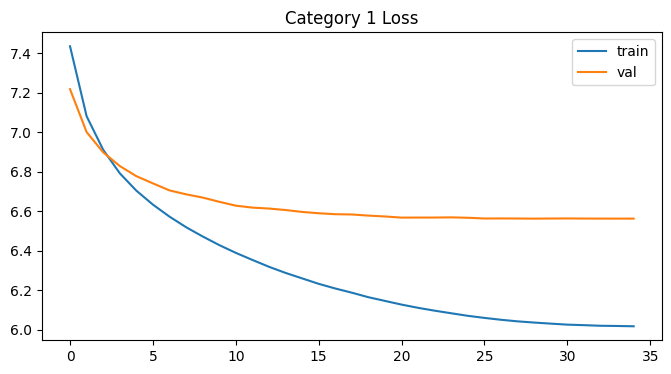

In [10]:
# ------------------ Train Category 1 (Natural) ------------------
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device used:', DEVICE)

cat1_model, cat1_hist = train_model(cat1_model, cat1_train, cat1_val, epochs=EPOCHS, lr=LR, device=DEVICE)

# Save artifacts
OUT = Path('q1_artifacts')
OUT.mkdir(exist_ok=True)
torch.save({'model':cat1_model.state_dict(), 'stoi':cat1_ds.stoi, 'itos':cat1_ds.itos}, OUT/ 'cat1_model.pt')
print('Saved Category 1 model to', OUT/'cat1_model.pt')

# Plot losses
plt.figure(figsize=(8,4))
plt.plot(cat1_hist['train'], label='train')
plt.plot(cat1_hist['val'], label='val')
plt.title('Category 1 Loss')
plt.legend()
plt.show()


Device used: cuda
Epoch 1: train=4.3697 val=3.9201
Epoch 2: train=3.9156 val=3.7378
Epoch 3: train=3.7600 val=3.6319
Epoch 4: train=3.6550 val=3.5568
Epoch 5: train=3.5742 val=3.4940
Epoch 6: train=3.5070 val=3.4444
Epoch 7: train=3.4517 val=3.3997
Epoch 8: train=3.4035 val=3.3656
Epoch 9: train=3.3611 val=3.3329
Epoch 10: train=3.3244 val=3.3080
Epoch 11: train=3.2909 val=3.2833
Epoch 12: train=3.2608 val=3.2638
Epoch 13: train=3.2339 val=3.2443
Epoch 14: train=3.2087 val=3.2245
Epoch 15: train=3.1854 val=3.2110
Epoch 16: train=3.1645 val=3.1956
Epoch 17: train=3.1447 val=3.1852
Epoch 18: train=3.1271 val=3.1747
Epoch 19: train=3.1099 val=3.1644
Epoch 20: train=3.0943 val=3.1543
Epoch 21: train=3.0795 val=3.1490
Epoch 22: train=3.0671 val=3.1395
Epoch 23: train=3.0546 val=3.1337
Epoch 24: train=3.0429 val=3.1279
Epoch 25: train=3.0326 val=3.1238
Epoch 26: train=3.0236 val=3.1197
Epoch 27: train=3.0159 val=3.1157
Epoch 28: train=3.0093 val=3.1132
Epoch 29: train=3.0021 val=3.1115
Epoch

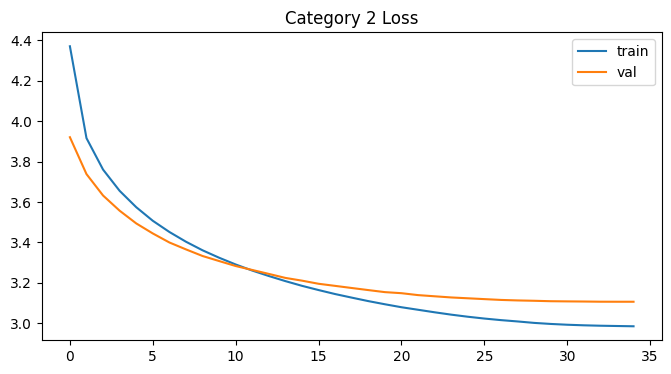

In [ ]:
# ------------------ Train Category 2 (Structured) ------------------
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device used:', DEVICE)
cat2_model, cat2_hist = train_model(cat2_model, cat2_train, cat2_val, epochs=EPOCHS, lr=LR, device=DEVICE)

OUT =Path('q1_artifacts')
OUT.mkdir(exist_ok=True)

torch.save({'model':cat2_model.state_dict(), 'stoi':cat2_ds.stoi, 'itos':cat2_ds.itos}, OUT/ 'cat2_model.pt')
print('Saved Category 2 model to', OUT/'cat2_model.pt')

plt.figure(figsize=(8,4))
plt.plot(cat2_hist['train'], label='train')
plt.plot(cat2_hist['val'], label='val')
plt.title('Category 2 Loss')
plt.legend()
plt.show()


In [ ]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt


MODEL_TO_CONTINUE = 'cat1_model.pt' 


CONTINUE_EPOCHS = 20 
CONTINUE_LR = LR  # Often good to use a smaller LR for fine-tuning

CONTINUED_MODEL_SAVE_NAME = 'cat1_model_continued.pt'


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
OUT = Path('q1_artifacts')
model_path =OUT / MODEL_TO_CONTINUE

print(f"Attempting to load checkpoint from: {model_path}")
if not model_path.exists():
    print(f"Error: Model file not found at {model_path}.")
    print("Please run the main training cell (cell 9 or 10) first.")
else:
    checkpoint = torch.load(model_path, map_location=DEVICE)
    
    # Get vocab size from the checkpoint
    vocab_size = len(checkpoint['itos'])
    
    
    if MODEL_TO_CONTINUE =='cat1_model.pt':
        print("Instantiating Category 1 model structure...")
        continued_model = NextWordMLP(
            vocab_size=vocab_size,
            embed_dim=EMBED_DIM, 
            context=CONTEXT, 
            h1=HIDDEN1, 
            h2=HIDDEN2, 
            dropout=DROPOUT
        ).to(DEVICE)
        
        train_loader = cat1_train
        val_loader = cat1_val
        
    elif MODEL_TO_CONTINUE == 'cat2_model.pt':
        print("Instantiating Category 2 model structure...")
        continued_model = NextWordMLP(
            vocab_size=vocab_size,
            embed_dim=EMBED_DIM, 
            context=CONTEXT,
            h1=HIDDEN1, 
            h2=HIDDEN2,
            dropout=DROPOUT
        ).to(DEVICE)
        
        # Select the correct data loaders
        train_loader = cat2_train
        val_loader = cat2_val
    else:
        raise ValueError("MODEL_TO_CONTINUE must be 'cat1_model.pt' or 'cat2_model.pt'")
    
    # Load the saved weights into the new model instance
    continued_model.load_state_dict(checkpoint['model'])
    print(f"Model weights loaded. Total params: {sum(p.numel() for p in continued_model.parameters())}")

    # --- Continue Training ---
    print(f"Continuing training for {CONTINUE_EPOCHS} epochs with LR={CONTINUE_LR}...")
    
    continued_model, history = train_model(
        continued_model, 
        train_loader, 
        val_loader, 
        epochs=CONTINUE_EPOCHS, 
        lr=CONTINUE_LR, 
        device=DEVICE
    )


    save_path = OUT / CONTINUED_MODEL_SAVE_NAME
    # We re-use the stoi/itos from the original checkpoint
    torch.save({
        'model': continued_model.state_dict(), 
        'stoi': checkpoint['stoi'], 
        'itos': checkpoint['itos']
    }, save_path)
    print(f"Saved continued model to: {save_path}")
    
    plt.figure(figsize=(8,4))
    plt.plot(history['train'], label='train')
    plt.plot(history['val'], label='val')
    plt.title(f'Continued Training Loss ({MODEL_TO_CONTINUE})')
    plt.legend()
    plt.show()

Category 1 embedding visualization (sample):


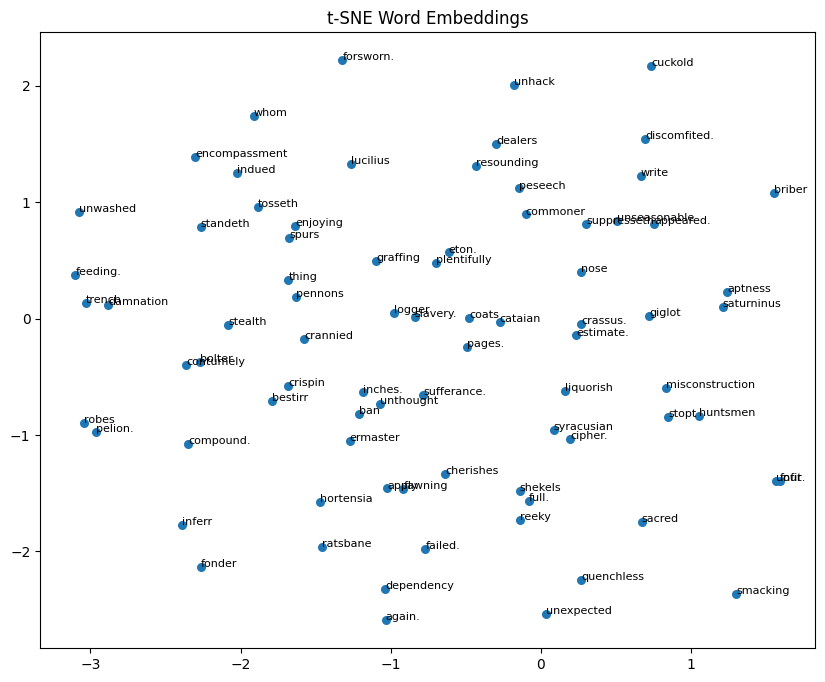

Category 2 embedding visualization (sample):


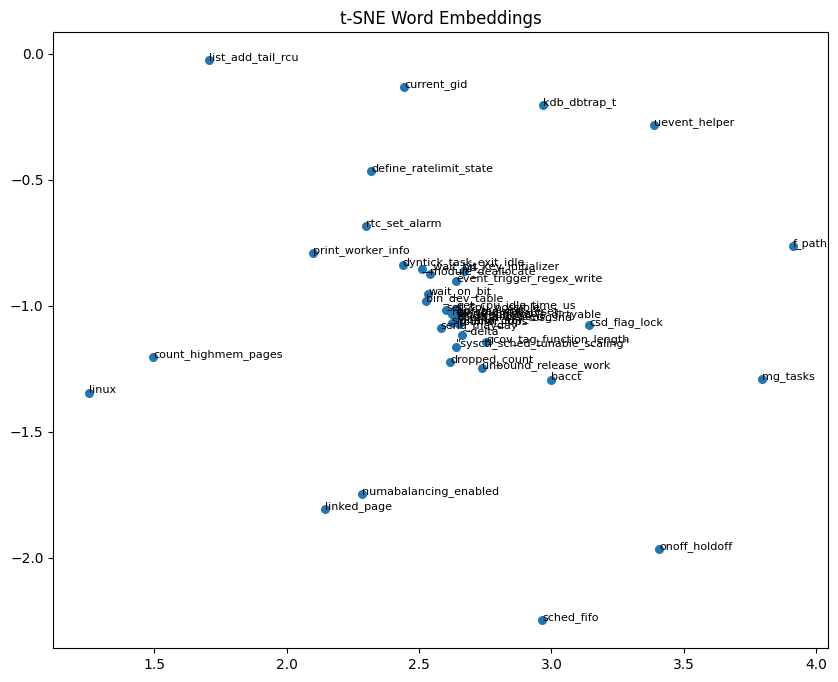

In [15]:
# ------------------ Embedding visualization (t-SNE) ------------------

def plot_embeddings(model, itos_map, n_samples=100):
    emb = model.embed.weight.data.cpu().numpy()
    vocab_size = len(itos_map)
    idxs = np.random.choice(range(vocab_size), min(n_samples, vocab_size), replace=False)
    tokens = [itos_map[i] for i in idxs]
    z = TSNE(n_components=2, random_state=SEED, perplexity=30).fit_transform(emb[idxs])
    plt.figure(figsize=(10,8))
    plt.scatter(z[:,0], z[:,1], s=30)
    for i,t in enumerate(tokens):
        plt.annotate(t, (z[i,0], z[i,1]), fontsize=8)
    plt.title('t-SNE Word Embeddings')
    plt.show()

print('Category 1 embedding visualization (sample):')
plot_embeddings(cat1_model, cat1_ds.itos, n_samples=80)

print('Category 2 embedding visualization (sample):')
plot_embeddings(cat2_model, cat2_ds.itos, n_samples=40)


In [ ]:
# ------------------ Generation utilities ------------------
import numpy as np

def sample_top_k(probs, k=TOP_K):
    topk_idx = np.argsort(probs)[-k:]
    topk_probs = probs[topk_idx]
    topk_probs = topk_probs / (topk_probs.sum() + 1e-12)
    return np.random.choice(topk_idx, p=topk_probs)

def predict_next(model, ds, context_words, k=5, temperature=TEMPERATURE):
    model.eval()
    stoi = ds.stoi
    itos =ds.itos
    unk =stoi.get(UNK)
    pad =stoi.get(PAD)
    idxs = [stoi.get(w, unk) for w in context_words]
    if len(idxs) < CONTEXT:
        idxs = [pad] * (CONTEXT - len(idxs)) + idxs
    else:
        idxs = idxs[-CONTEXT:]
    xb = torch.tensor([idxs], dtype=torch.long).to(DEVICE)
    with torch.no_grad():
        logits = model(xb)[0] / max(1e-8, temperature)
        probs = F.softmax(logits, dim=-1).cpu().numpy()
    words = []
    for _ in range(k):
        idx = sample_top_k(probs, k=TOP_K)
        words.append(itos[idx])
    return words

ctx = ['Their', 'in', 'do','men','from']
print('Category 1 (natural) predictions for context', ctx)
print(predict_next(cat1_model, cat1_ds, ctx, k=8))

ctx2 = ['int', 'rrln', '=', 'n','*']
print('Category 2 (structured) predictions for context', ctx2)
print(predict_next(cat2_model, cat2_ds, ctx2, k=8))


Category 1 (natural) predictions for context ['Their', 'in', 'do', 'men', 'from']
['pandarus.', 'pandarus.', 'necessity', 'ild', 'ild', 'doted', 'robin.', 'rescuing']
Category 2 (structured) predictions for context ['int', 'rrln', '=', 'n', '*']
['start', 'sizeof', 'sizeof', 'sizeof', 'start', 'start', 'start', 'sizeof']


## Comparative Analysis

After training both models, compare:

- dataset sizes, vocabularies
- validation losses (see plots above)
- qualitative generations (see demo outputs)


In [38]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 68.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.6 MB/s eta 0:00:00:00:01


In [42]:
%%writefile app.py
import streamlit as st

@st.cache_resource
def load_model(model_path):
    """
    Loads the model and vocab. This is cached so it only runs once.
    """
    try:
        checkpoint = torch.load(model_path, map_location=DEVICE)
        
        # Recreate the exact model architecture
        vocab_size = len(checkpoint['itos'])
        
        # ASSUMPTION: We must hard-code the params for each model
        # This resolves the assignment contradiction.
        if 'cat1' in model_path.name:
            model_params = {
                'context': DEFAULT_CONTEXT,
                'embed_dim': DEFAULT_EMBED_DIM,
                'h1': 1024,
                'h2': 512,
                'dropout': 0.4
            }
        elif 'cat2' in model_path.name:
            model_params = {
                'context': DEFAULT_CONTEXT,
                'embed_dim': DEFAULT_EMBED_DIM,
                'h1': 1024,
                'h2': 512,
                'dropout': 0.4
            }
        else:
            # Fallback for other models
            model_params = {
                'context': DEFAULT_CONTEXT,
                'embed_dim': DEFAULT_EMBED_DIM,
                'h1': 512,
                'h2': 256,
                'dropout': 0.3
            }
            
        model = NextWordMLP(
            vocab_size=vocab_size,
            embed_dim=model_params['embed_dim'],
            context=model_params['context'],
            h1=model_params['h1'],
            h2=model_params['h2'],
            dropout=model_params['dropout']
        )
        
        model.load_state_dict(checkpoint['model'])
        model.to(DEVICE)
        model.eval()
        
        return model, checkpoint['stoi'], checkpoint['itos'], model_params

    except FileNotFoundError:
        st.error(f"Model file not found at {model_path}. Did you create the 'q1_artifacts' folder and add your .pt files?")
        return None, None, None, None
    except Exception as e:
        st.error(f"An error occurred loading the model: {e}")
        return None, None, None, None

# ----------------------------------------------------------------------
# 4. Streamlit UI
# ----------------------------------------------------------------------

st.set_page_config(layout="wide")
st.title("Next-Word Prediction with MLP")

# --- Sidebar Controls ---
st.sidebar.title("Controls")

ARTIFACTS_DIR = '/kaggle/working/q1_artifacts'

model_options = {
    "Category 1: Natural (Shakespeare)": f'{ARTIFACTS_DIR} / cat1_model.pt',
    "Category 2: Structured (Linux C Code)": f'{ARTIFACTS_DIR} / cat2_model.pt'
}
model_choice = st.sidebar.selectbox("Choose Model Variant", model_options.keys())
model_path = model_options[model_choice]

# Load the selected model
model, stoi, itos, params = load_model(model_path)

if model:
    # Display the loaded model's parameters (as required by assignment)
    st.sidebar.subheader("Loaded Model Parameters")
    st.sidebar.text(f"Context Window: {params['context']}")
    st.sidebar.text(f"Embedding Dim: {params['embed_dim']}")
    st.sidebar.text(f"Hidden 1: {params['h1']}")
    st.sidebar.text(f"Hidden 2: {params['h2']}")
    st.sidebar.text(f"Activation: ReLU")
    st.sidebar.text(f"Vocab Size: {len(stoi)}")

    # --- Generation Controls ---
    st.sidebar.subheader("Generation Settings")
    seed = st.sidebar.number_input("Random Seed", value=1337)
    temperature = st.sidebar.slider("Temperature (Randomness)", 0.1, 2.0, 0.8, 0.1)
    top_k = st.sidebar.slider("Top-K Sampling (Focus)", 1, 50, 10, 1)
    num_to_gen = st.sidebar.number_input("Words to Generate", 1, 100, 20)

    # Set seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)

    # --- Main Page ---
    st.info("Enter some starting text. The model will generate the next words autoregressively.")
    
    # Set default text based on model
    default_text = "Woe, the" if 'cat1' in model_path.name else "int main ( ) {"
    user_input = st.text_area("Enter your context text:", default_text, height=150)

    if st.button("Generate"):
        # Tokenize user input
        if 'cat1' in model_path.name:
            # Natural language: simple split
            tokens = user_input.lower().split()
        else:
            # Code: find all non-space chunks
            tokens = re.findall(r'[^\s]+', user_input.lower())
        
        if not tokens:
            st.warning("Please enter some text to start.")
        else:
            with st.spinner(f"Generating {num_to_gen} words..."):
                generated_text = generate_sequence(
                    model, stoi, itos, tokens,
                    num_to_gen, temperature, top_k, params
                )
            
            st.subheader("Generated Text")
            # Display the full sequence (input + generated)
            st.markdown(f"**{user_input}** <span style='color: #0078D4; font-weight: bold;'>{generated_text}</span>", unsafe_allow_html=True)
else:
    st.error("Please place your trained `cat1_model.pt` and `cat2_model.pt` files in a folder named `q1_artifacts` and restart the app.")


Writing app.py
